In [39]:
import numpy as np
import networkx as nx
import kmapper as km
import sklearn
import warnings
import matplotlib.pyplot as plt
import signal
import time
import random



warnings.filterwarnings("ignore")

In [61]:
rows = 45
cols = 7

# Create an empty 2D matrix
matrix = [[None] * cols for _ in range(rows)]

# Populate the matrix with NetworkX graphs
for t in range(cols):
    n = t + 3
    max_edge = round(n*(n-1)/2) - n
    pos_row = 0
    G = nx.star_graph(n)
    matrix[pos_row][t] = G
    pos_row += 1
    curr_G = G.copy()
    for i in range(1, n+1):
        for j in range(i+1, n+1):
            # Add the edge between nodes i and j
            curr_G.add_edge(i, j)
            matrix[pos_row][t] = curr_G.copy()
            pos_row += 1
    

In [63]:
rows = 3
cols = 3

# Create an empty 2D matrix
matrix = [[None] * cols for _ in range(rows)]

# Populate the matrix with NetworkX graphs
for t in range(cols):
    n = t + 3
    G = nx.star_graph(n)
    matrix[0][t] = G
    pos_row += 1
    curr_G = G.copy()
    for i in range(1,rows):
        node1 = random.randint(1,n)
        node2 = random.randint(1,n)
#         node1,node2 = random.sample(1,n)
        while G.has_edge(node1,node2) or node1 == node2 :
            node1 = random.randint(1,n)
            node2 = random.randint(1,n)
        curr_G.add_edge(node1,node2)
        matrix[i][t]= curr_G.copy()
    

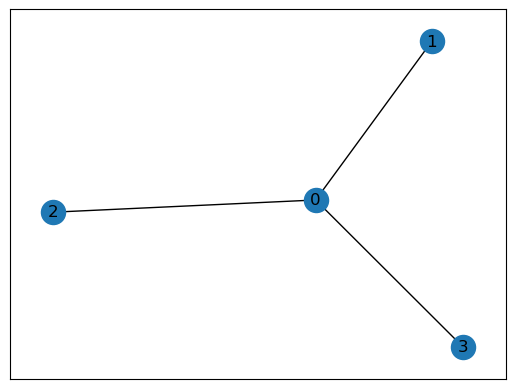

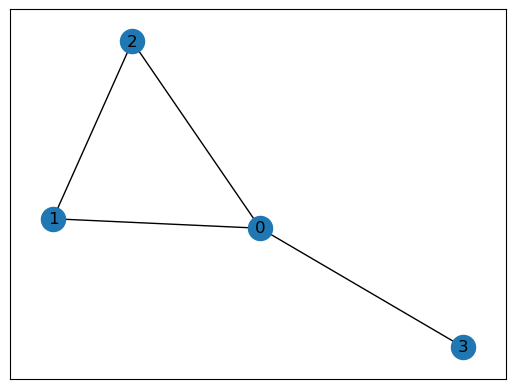

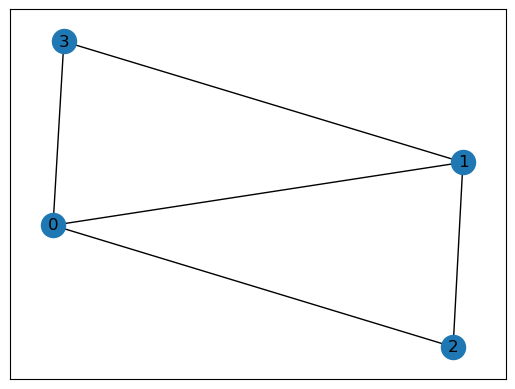

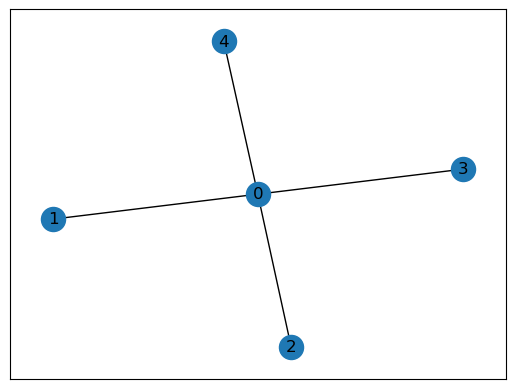

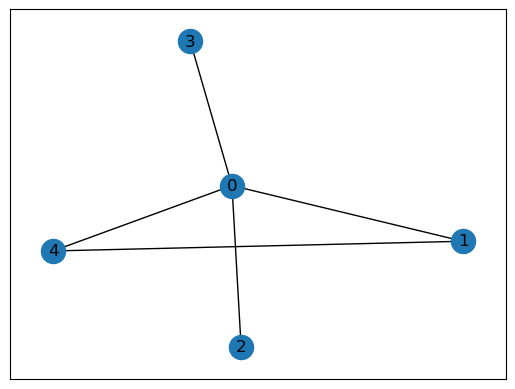

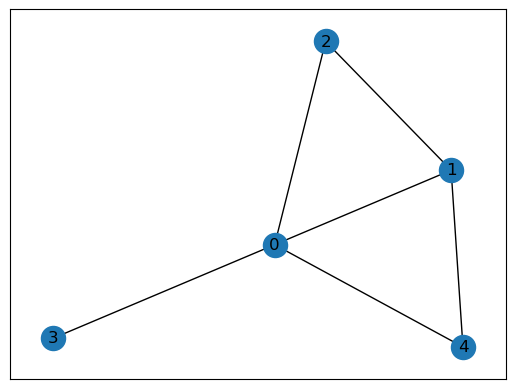

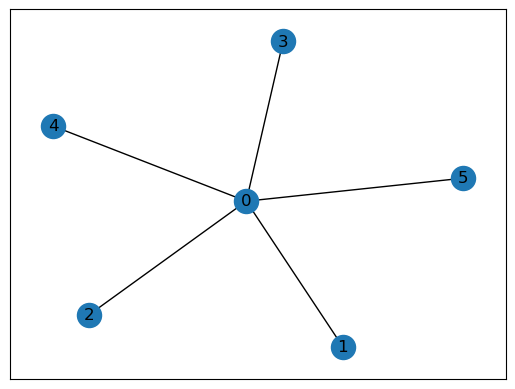

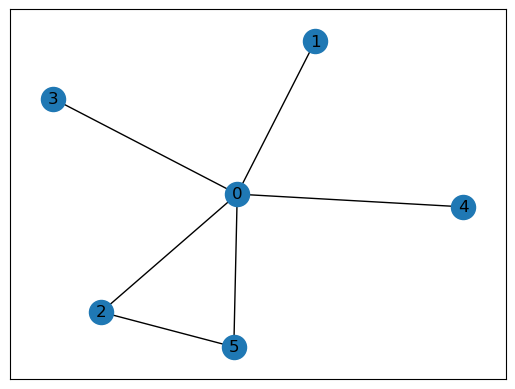

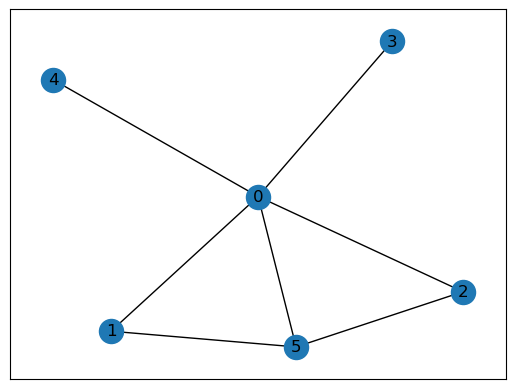

In [64]:
for i in range(cols):
    for j in range(rows):
        G = matrix[j][i]
        pos = nx.spring_layout(G)
        nx.draw_networkx(G, with_labels=True)
        plt.show()
        

In [20]:
def select_k(spectrum, minimum_energy = 0.9):
    running_total = 0.0 
    
    total = sum(spectrum)
    if total == 0.0:
        return len(spectrum)
    for i in range(len(spectrum)):
        running_total += spectrum[i]
        if running_total / total >= minimum_energy:
            return i + 1
    return len(spectrum)

In [21]:
def calculate_similarity(graph1,graph2):
    laplacian1 = nx.spectrum.laplacian_spectrum(graph1)
    laplacian2 = nx.spectrum.laplacian_spectrum(graph2)
    
    k1 = select_k(laplacian1)
    k2 = select_k(laplacian2)
    k = min(k1, k2) #k are different between the two graphs, then use the smaller one.
    similarity = sum((laplacian1[:k] - laplacian2[:k])**2) #sum of the squared differences between the largest k eigenvalues
    return similarity


In [22]:
def extract_graph_features(graph):
#     pr = nx.pagerank(graph,0.9)
    dc = nx.degree_centrality(graph)
    cc = nx.closeness_centrality(graph)
    bx = nx.betweenness_centrality(graph)
    c = nx.clustering(graph)
    
    #create list for each features
#     pr_list =  [i for i in pr.values()]
    dc_list =  [i for i in dc.values()]
    cc_list =  [i for i in cc.values()]
    bx_list =  [i for i in bx.values()]
    c_list =  [i for i in c.values()]
    d_list = [val for (node, val) in graph.degree()]
    data = np.column_stack((dc_list,d_list))
    return data

In [59]:
def TDA_transformation(data):
    Xfilt = data
    mapper = km.KeplerMapper()
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    Xfilt = scaler.fit_transform(Xfilt)
    lens = mapper.fit_transform(Xfilt, projection=sklearn.manifold.TSNE())
    cls = 2  # We use cls= 5

    graph = mapper.map(lens,Xfilt,clusterer=sklearn.cluster.KMeans(n_clusters=cls),
                       cover=km.Cover(n_cubes=2, perc_overlap=0.2))
    
    return km.to_nx(graph)

In [24]:
def is_TDA_capture_better(learning_graph, neighbour_graph):
    isBetter = False
    original_similarity_score = calculate_similarity(learning_graph,neighbour_graph)
    TDA_learning_graph = TDA_transformation(extract_graph_features(learning_graph))
    TDA_neighbour_graph = TDA_transformation(extract_graph_features(neighbour_graph))
    TDA_similarity_score = calculate_similarity(TDA_learning_graph,TDA_neighbour_graph)
    if(TDA_similarity_score < original_similarity_score ): isBetter = True
    return isBetter

In [27]:
def compare_similarity_TDA_graph(row,col, matrix ):
    case_TDA_better = 0
    total_cases = 0
    
    
    for i in range(col):
        for j in range(row):
            target_graph = matrix[j][i]
            if target_graph != None:
            #Compare current graph with neighbour graphs
                if(j-1 >=0):
                    neighbour_graph = matrix[j - 1][i]
                    if neighbour_graph != None:
                        if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                        total_cases += 1
                if(i + 1 < col):
                    neighbour_graph =matrix[j][i+1]
                    if neighbour_graph != None:
                        if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                        total_cases += 1
                
    return case_TDA_better/total_cases

In [66]:
score = compare_similarity_TDA_graph(3,3,matrix)
score

1.0